# Setup

In [1]:
using Plots

In [2]:
#set up "camera" with coordinates (x,y) = α,β ; inclined 75 deg from pole
nx = ny = 2048; rlim = 3e4
a = range(0,stop=nx-1,length=nx)./(nx-1)*rlim.-rlim/2; b = range(0,stop=ny-1,length=ny)./(ny-1)*rlim.-rlim/2

meshgrid(x,y) = (repeat(x,outer=length(y)), repeat(y,inner=length(x)))
α,β = meshgrid(a,b) 

i = 75/180*π; cosi = cos(i); sini = sin(i) #inclination angle in rad

# calculate the raal and azimuthal coordinates wher rays sent from camera pixels intersect the "disk" in the equatorial plane, working back from camera
r = reshape(sqrt.(β.^2 ./cosi^2 .+ α.^2),nx,ny); φ = reshape(atan.(β,α*cosi),nx,ny) 
ν = 1 .+ sqrt.(1 ./(2 .*r)).*sini.*cos.(φ) #Doppler shift G = M = c = 1; unclear why 2?
rMin = 1e3; #inner disk boundary
println(maximum(vec(r))/rMin) #agrees with Python code

59.86522969814774


In [3]:
getA(A0,x,γ) = A0.*x.^γ

# This φ is with observer at φ = 0, see Waters+ 2016
function dvldl(r,sini,φ,windWeight=0) #line of sight velocity gradient
    windφ = cos.(φ).*(√2 .*cos.(φ).+sin.(φ)./2)
    diskφ = cos.(φ).*sin.(φ)./2
    φTerm = windWeight.*windφ .+ (1-windWeight).*diskφ
    dvl = 3 .*sqrt.(1 ./(2 .*r))./r .*sini^2 .*φTerm #sqrt is just v_φ in circular gravity, but shouldn't just be sqrt(GM/r)? why extra √2?
    return dvl
end

#this is the intensity in terms of the line optical depth τ and the line of sight velocity gradient
intensity(A,r,∇v,τ) = A./(4*π.*r.^2).*abs.(∇v).*(1-exp(-τ)) #see equation 22 in Waters

intensity (generic function with 1 method)

# Sample calculation + image

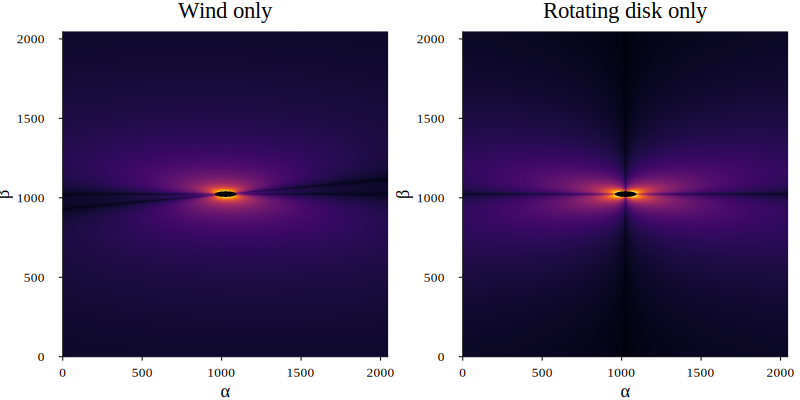

In [4]:
#sample calc
γ = 1; A0 = 1; τ = 10 
φn = φ .+ π/2 #+π/2 because we are different than CM by 90 deg
∇vWind = dvldl(r,sini,φn,1) #φTerm only has wind component
∇vDisk = dvldl(r,sini,φn) #φTerm only has disk component

A = getA(A0,r,γ)

#calculate intensities for both cases
IWind = intensity(A,r,∇vWind,τ); IDisk = intensity(A,r,∇vDisk,τ)
IWind[r.<rMin] .= 0.; IDisk[r.<rMin] .= 0. #set intensities to zero inside the inner edge of disk we hard-coded above
default(widen=false,tickdirection=:out,fontfamily="times")
pWind=heatmap((IWind').^(1/4),aspect_ratio=:equal,colorbar=false,xlims=(0,nx),ylims=(0,ny),title="Wind only",xlabel="α",ylabel="β"); 
pDisk=heatmap((IDisk').^(1/4),aspect_ratio=:equal,colorbar=false,xlims=(0,nx),ylims=(0,ny),title="Rotating disk only",xlabel="α",ylabel="β") #always plot transpose in Julia to match Python, row vs col major
plot(pWind,pDisk,size=(800,400)) #matches what we had in Python notebook

# Line profile sample

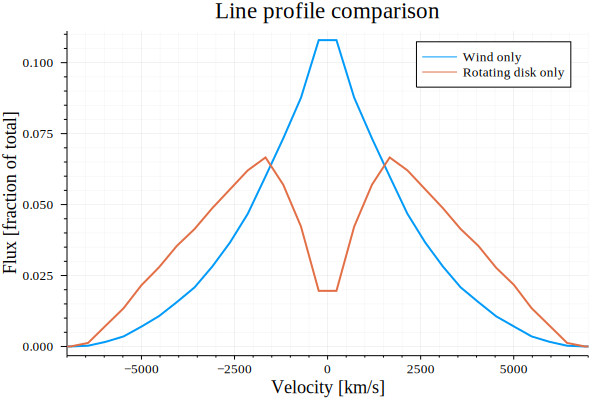

In [5]:
#now let's make plots of line profiles, flux vs velocity (proxy for λ) for both cases
#disk should be double peaked from rotation but wind should have most emission near v = 0 so should be single peaked
# plot((vec(ν).-1).*3e5,vec(IWind)./sum(vec(IWind))) #need to use this dumb binned statistic thing but can't figure out how to do it by hand, really annoyed
# plot((vec(ν).-1).*3e5,vec(IDisk)./sum(vec(IDisk)))

using PyCall
scipyStats = pyimport("scipy.stats"); binnedStat = scipyStats.binned_statistic #admitting defeat and just using stupid Python way
bins = 100
fluxW,νEdges,n=binnedStat(vec(ν),vec(IWind),statistic="sum",bins=bins)
fluxD,νEdges,n=binnedStat(vec(ν),vec(IDisk),statistic="sum",bins=bins)
νBin = 0.5*(νEdges[2:end].+νEdges[1:end-1])
plot((νBin.-1).*3e5,fluxW./sum(fluxW),label="Wind only",lw=2)
plot!((νBin.-1).*3e5,fluxD./sum(fluxD),label="Rotating disk only",lw=2)
plot!(xlims=(-7e3,7e3),widen=true,minorticks=true,minorgrid=true,title="Line profile comparison",xlabel="Velocity [km/s]",ylabel="Flux [fraction of total]")
#matches Python notebook

# Generalizing 

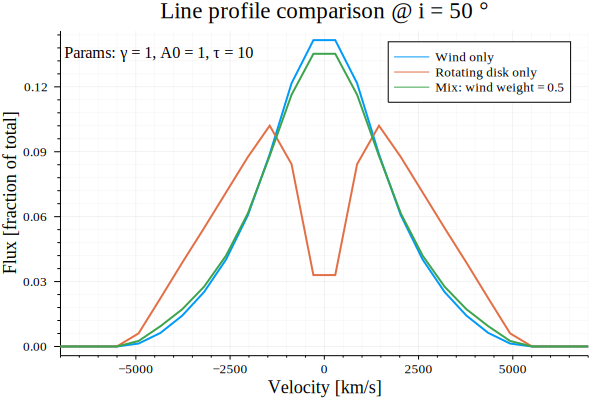

In [6]:
function setup(i=75,nx=2048,ny=2048,rlim=3e4)
    #set up "camera" with coordinates (x,y) = α,β ; inclined 75 deg from pole
    nx = ny = 2048; rlim = 3e4
    a = range(0,stop=nx-1,length=nx)./(nx-1)*rlim.-rlim/2; b = range(0,stop=ny-1,length=ny)./(ny-1)*rlim.-rlim/2

    meshgrid(x,y) = (repeat(x,outer=length(y)), repeat(y,inner=length(x)))
    α,β = meshgrid(a,b) 

    i = i/180*π; cosi = cos(i); sini = sin(i) #inclination angle in rad

    # calculate the raal and azimuthal coordinates wher rays sent from camera pixels intersect the "disk" in the equatorial plane, working back from camera
    r = reshape(sqrt.(β.^2 ./cosi^2 .+ α.^2),nx,ny); φ = reshape(atan.(β,α.*cosi),nx,ny) 
    ν = 1 .+ sqrt.(1 ./(2 .*r)).*sini.*cos.(φ) #Doppler shift G = M = c = 1; unclear why 2?
    return α,β,r,ν,φ,sini
end

function getIntensity(r,φ,windWeight,sini,rMin=1e3,γ=1,A0=1,τ=10)
    φn = φ .+ π/2 #+π/2 because we are different than CM by 90 deg
    ∇v = dvldl(r,sini,φn,windWeight)
    A = getA(A0,r,γ)
    #calculate intensities
    I = intensity(A,r,∇v,τ); I[r.<rMin] .= 0.
    return I,γ,A0,τ
end

function plotProfile(ν,I,IWind,IDisk,windWeight,i,γ,A0,τ,bins=100)
    scipyStats = pyimport("scipy.stats"); binnedStat = scipyStats.binned_statistic #admitting defeat and just using stupid Python way
    fluxW,νEdges,n=binnedStat(vec(ν),vec(IWind),statistic="sum",bins=bins)
    fluxD,νEdges,n=binnedStat(vec(ν),vec(IDisk),statistic="sum",bins=bins)
    flux,νEdges,n=binnedStat(vec(ν),vec(I),statistic="sum",bins=bins)
    νBin = 0.5*(νEdges[2:end].+νEdges[1:end-1])
    p=plot((νBin.-1).*3e5,fluxW./sum(fluxW),label="Wind only",lw=2)
    p=plot!((νBin.-1).*3e5,fluxD./sum(fluxD),label="Rotating disk only",lw=2)
    p=plot!((νBin.-1).*3e5,flux./sum(flux),label="Mix: wind weight = $windWeight",lw=2)
    p=plot!(xlims=(-7e3,7e3),widen=true,minorticks=true,minorgrid=true,title="Line profile comparison @ i = $i °",xlabel="Velocity [km/s]",ylabel="Flux [fraction of total]")
    p=annotate!((-6900,ylims(p)[2]-0.01,Plots.text("Params: γ = $γ, A0 = $A0, τ = $τ","times",10,"black",:left)))
    return p
end

#a test
function main(i=75,windWeight=0.5)
    α,β,r,ν,φ,sini = setup(i)
    IWind,γ,A0,τ = getIntensity(r,φ,1,sini); IDisk,γ,A0,τ = getIntensity(r,φ,0,sini)
    I,γ,A0,τ = getIntensity(r,φ,windWeight,sini)
    p = plotProfile(ν,I,IWind,IDisk,windWeight,i,γ,A0,τ)
    return p
end
p = main(50)
plot(p)


In [8]:
#interactive plot, kinda gimmicky
using Interact
i=spinbox([0,90],label="i",value=75)
windWeight=spinbox([0,1],label="wind weight",value=0.5)
interact = map(main,i,windWeight)
vbox(
    hbox(i,windWeight),
    interact)

(div { style=Dict("display" => "flex", "flex-direction" => "column") }
  (div { style=Dict("display" => "flex", "flex-direction" => "row") }
    Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:attributes => Dict{Any, Any}(:type => "number", Symbol("data-bind") => "numericValue: value, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}"), :placeholder => [0, 90], :className => "input ", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}())], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "value" => (Observable{Union{Nothing, Int64}} with 2 listeners. Value:
75, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/kirk/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/kirk/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/kirk/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/home/kirk/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/home/kirk/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "value" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"value\"]()) ? (this.valueFromJulia[\"value\"]=true, this.model[\"value\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f3f614342b0, Task (runnable) @0x00007f3f614342b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"4723159941081410226\",\"id\":\"3341019922931827854\",\"type\":\"observable\"}),\"value\":WebIO.getval({\"name\":\"value\",\"scope\":\"4723159941081410226\",\"id\":\"2157119529529707941\",\"type\":\"observable\"})};\n    var self = this;\n 

# What does this show?

Using just the terms in Waters+ 2016 we see replicate the results in CM96 &mdash; that the contribution of a "disk wind" term to the line profile is significant, even at relatively low weights, and can produce broad, single-peaked line profiles at a variety of inclination angles. 

## next steps

1. re-do photocenter calculations (see other notebook)

2. add line profile data to plot and fit, return best fit parameters &mdash <span style="color:red">data done below! should use Mamba MCMC to fit?</span>

3. add new terms to line of sight velocity gradient (gross math).

# Comparing to data

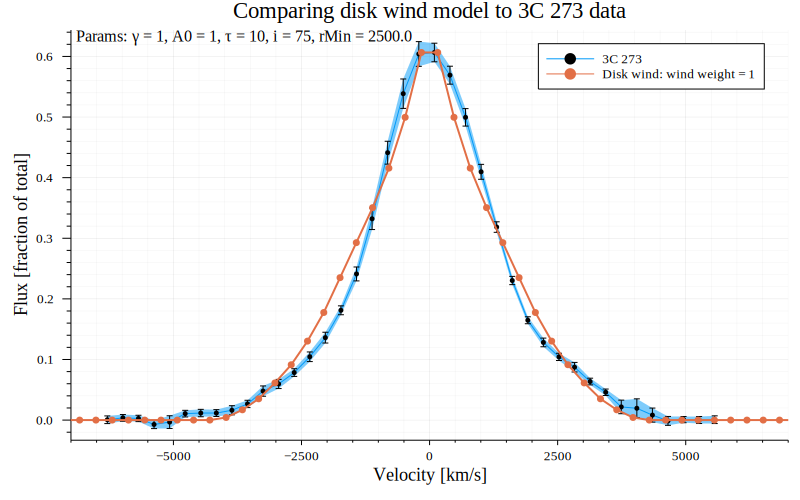

In [8]:
using PyCall, Plots.Measures
@pyimport pickle

function readPickle(file)
    data = nothing
    @pywith pybuiltin("open")(file,"rb") as f begin
        data = pickle.load(f,encoding="latin1")
    end
    return data
end

data = readPickle("3c273_juljanmarmay_append_gilles_specirf_wide_v6.p")
λCen = 2.172
vel = (data[1].-λCen)./λCen.*3e5
p = plot(vel,data[4],ribbon=data[7],yerr=data[7],marker=:circle,markercolor=:black,markersize=3,label="3C 273")
p = plot!(widen=true,minorgrid=true,xlabel="Velocity [km/s]",ylabel="Flux [fraction of total]",title="Comparing disk wind model to 3C 273 data",size=(800,500),xlims=(-7e3,7e3))

i = 75; rMin = 2.5*1e3; windWeight = 1; bins = 150 #150 good visual match to data point spacing

α,β,r,ν,φ,sini = setup(i)
I,γ,A0,τ = getIntensity(r,φ,windWeight,sini,2.5*1e3)
flux,νEdges,n = binnedStat(vec(ν),vec(I),statistic="sum",bins=bins)
νBin = 0.5*(νEdges[2:end].+νEdges[1:end-1])

p = plot!((νBin.-1).*3e5,flux./maximum(flux)*maximum(data[4]),marker=:circle,markerstrokewidth=0,label="Disk wind: wind weight = $windWeight",lw=2)
p = annotate!((-6900,ylims(p)[2]-0.01,Plots.text("Params: γ = $γ, A0 = $A0, τ = $τ, i = $i, rMin = $rMin","times",10,"black",:left)))
plot(p,left_margin=5mm,bottom_margin=5mm)

In [71]:
#interactive version
using Interact
function interactData(i=75,rMin=1e3,windWeight=1,bins=100)
    data = readPickle("3c273_juljanmarmay_append_gilles_specirf_wide_v6.p")
    λCen = 2.172
    vel = (data[1].-λCen)./λCen.*3e5
    p = plot(vel,data[4],ribbon=data[7],yerr=data[7],marker=:circle,markercolor=:black,markersize=3,label="3C 273")
    p = plot!(widen=true,minorgrid=true,xlabel="Velocity [km/s]",ylabel="Flux [fraction of total]",title="Comparing disk wind model to 3C 273 data",size=(800,500),xlims=(-7e3,7e3))
    α,β,r,ν,φ,sini = setup(i)
    I,γ,A0,τ = getIntensity(r,φ,windWeight,sini,rMin)
    flux,νEdges,n = binnedStat(vec(ν),vec(I),statistic="sum",bins=bins)
    νBin = 0.5*(νEdges[2:end].+νEdges[1:end-1])
    p = plot!((νBin.-1).*3e5,flux./maximum(flux)*maximum(data[4]),label="Disk wind: wind weight = $windWeight",lw=2)
    p = annotate!((-6900,ylims(p)[2]-0.01,Plots.text("Params: γ = $γ, A0 = $A0, τ = $τ, i = $i, rMin = $rMin","times",10,"black",:left)))
    plot(p,left_margin=5mm,bottom_margin=5mm)
end

i=spinbox([0,90],label="i",value=75)
windWeight=spinbox([0,1],label="wind weight",value=1)
rMin=spinbox(label="rMin",value=1e3)
bins=spinbox(label="bins",value=100)
interact = map(interactData,i,rMin,windWeight,bins)
vbox(
    hbox(i,windWeight),
    hbox(rMin,bins),
    interact)

(div { style=Dict("display" => "flex", "flex-direction" => "column") }
  (div { style=Dict("display" => "flex", "flex-direction" => "row") }
    Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:attributes => Dict{Any, Any}(:type => "number", Symbol("data-bind") => "numericValue: value, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}"), :placeholder => [0, 90], :className => "input ", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}())], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "value" => (Observable{Union{Nothing, Int64}} with 2 listeners. Value:
75, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/kirk/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/kirk/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/kirk/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/home/kirk/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/home/kirk/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "value" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"value\"]()) ? (this.valueFromJulia[\"value\"]=true, this.model[\"value\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f3f34c73b20, Task (runnable) @0x00007f3f34c73b20), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"3969859661164679208\",\"id\":\"1721327417127060073\",\"type\":\"observable\"}),\"value\":WebIO.getval({\"name\":\"value\",\"scope\":\"3969859661164679208\",\"id\":\"16573602658229389254\",\"type\":\"observable\"})};\n    var self = this;\n

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/kirk/.julia/packages/PyCall/BD546/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('zero-size array to reduction operation minimum which has no identity')
  File "/home/kirk/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py", line 183, in binned_statistic
    [x], values, statistic, bins, range)
  File "/home/kirk/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py", line 567, in binned_statistic_dd
    binnumbers = _bin_numbers(sample, nbin, edges, dedges)
  File "/home/kirk/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py", line 727, in _bin_numbers
    dedges_min = dedges[i].min()
  File "/home/kirk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py", line 43, in _amin
    return umr_minimum(a, axis, None, out, keepdims, initial, where)


# Finding best fits

In [81]:
using AffineInvariantMCMC #this is equivalent to Python's emcee package, check with Aimee on this -- WIP

numdims = 5
numwalkers = 100
thinning = 10
numsamples_perwalker = 1000
burnin = 100

const stds = exp.(5 .* randn(numdims))
const means = 1 .+ 5 .* rand(numdims)
llhood = x->begin
	retval = 0.
	for i in 1:length(x)
		retval -= .5 * ((x[i] - means[i]) / stds[i]) ^ 2
	end
	return retval
end
x0 = rand(numdims, numwalkers) .* 10 .- 5
chain, llhoodvals = AffineInvariantMCMC.sample(llhood, numwalkers, x0, burnin, 1)
chain, llhoodvals = AffineInvariantMCMC.sample(llhood, numwalkers, chain[:, :, end], numsamples_perwalker, thinning)
flatchain, flatllhoodvals = AffineInvariantMCMC.flattenmcmcarray(chain, llhoodvals)
flatchain

5×10000 Matrix{Float64}:
 -6.8868    2.40364  -1.38711   1.01103   1.63911  …  -654.998      922.469
  3.74192   3.74185   3.74198   3.74149   3.7418         3.742        3.74198
 38.4373   -1.36204  11.9754    3.03224   1.21162     7129.37     -4007.35
 14.4085   -2.52847   8.17685  -1.95744  -2.33641        4.56589      2.62989
  3.14748   3.14744   3.1474    3.14692   3.14723        3.14751      3.1474

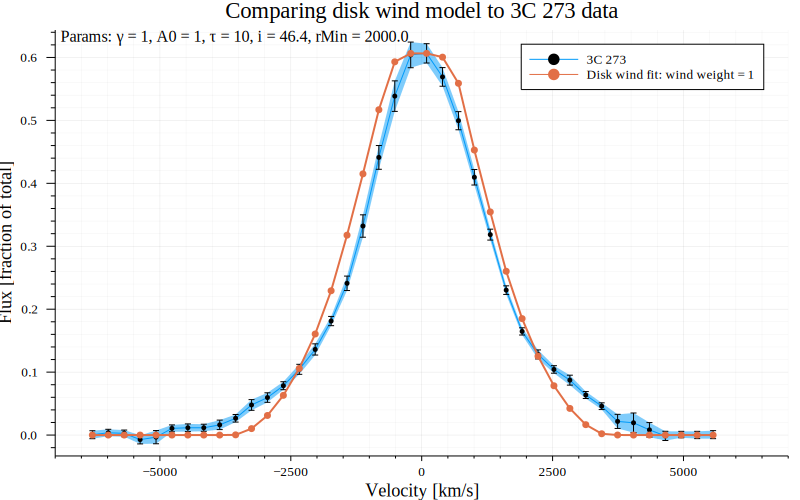

In [99]:
#least squares until I figure above out? turns out this is hard also -- this doesn't do anything it just converges to whatever it started with, actually it does do something sometimes..?
using LsqFit, SimplePCHIP
#generate fit function by interpolating among the bins, so that it's a function of "x" (v)
#then minimize that along the data points?
function lineProfile(ν,params,data=data) #incredibly inefficient to calculate the full thing at each step, but otherwise need to go back to beginning and setup differently?
    i,rMin = params
    α,β,r,νloc,φ,sini = setup(i) #this ν is discrete, we will interpolate to make it continuous for fitting
    I,γ,A0,τ = getIntensity(r,φ,1,sini,rMin) #use maximal wind case
    flux,νEdges,n = binnedStat(vec(νloc),vec(I),statistic="sum",bins=150)
    νBin = 0.5*(νEdges[2:end].+νEdges[1:end-1]) #still discrete
    x = (νBin.-1).*3e5; y = flux./maximum(flux).*maximum(data[4])
    interp = SimplePCHIP.interpolate(x,y) #returns functional form of line profile from interpolation
    return interp.(ν) #this is the interpolated value as a fx of any ν
end

test = lineProfile(3000,(75,1e3))
νRange = range(-5000,stop=5000,length=100) #takes ~30 sec for 100 pts
p0 = [50,2e3]
vel = (data[1].-λCen)./λCen.*3e5
fit = curve_fit(lineProfile,vel,data[4],p0)
p = plot(vel,data[4],ribbon=data[7],yerr=data[7],marker=:circle,markercolor=:black,markersize=3,label="3C 273")
p = plot!(widen=true,minorgrid=true,xlabel="Velocity [km/s]",ylabel="Flux [fraction of total]",title="Comparing disk wind model to 3C 273 data",size=(800,500),xlims=(-7e3,7e3))
p = plot!(vel,lineProfile(vel,fit.param),marker=:circle,markerstrokewidth=0,label="Disk wind fit: wind weight = $windWeight",lw=2)
p = annotate!((-6900,ylims(p)[2]-0.01,Plots.text("Params: γ = $γ, A0 = $A0, τ = $τ, i = $(round(fit.param[1],sigdigits=3)), rMin = $(round(fit.param[2],sigdigits=3))","times",10,"black",:left)))

In [107]:
#let's write a shitty MC routine by hand to sample the distrubtion of possible fit "solutions" -- takes like 2 hours to run, not that informative? maybe will let run longer
function shittyMC(p0,perturb,data,maxIter=100,nWalk=10,pSwitch=0.01,converge=0.001)
    solutions = Array{typeof(Array{Float64,1}(undef,length(p0))),1}(undef,nWalk) #initialize array
    i0,rMin0 = p0; pi,prMin = perturb
    for n=1:nWalk
        println("walker $n/$nWalk")
        converged = false; iter = 1
        signi = rand() < 0.5 ? -1 : 1; signr = rand() < 0.5 ? -1 : 1
        i,rMin = i0+signi*pi,rMin0+signr*prMin #initial nudges from guess, should convert to random draws from range to explore more of parameter space?
        while converged == false && iter < maxIter
            vel = (data[1].-λCen)./λCen.*3e5
            iNew,rMinNew = curve_fit(lineProfile,vel,data[4],[i,rMin]).param
            Δi = abs(iNew-i)/i; Δr = abs(rMinNew-rMin)/rMin
            if Δi < converge || Δr < converge || iter == maxIter-1
                i = iNew; rMin = rMinNew
                solutions[n] = [i,rMin]
                converged == true
            else
                signi = sign(iNew-i); signr = sign(rMinNew-rMin)
                i = iNew + signi*pi; rMin = rMinNew + signr*prMin
                if rand() < pSwitch #occasionally randomly try switching directions
                    i = iNew + -1*signi*pi
                end
                if rand() < pSwitch #keep r decision independent of i
                    rMin = rMinNew + -1*signr*prMin
                end
            end
            iter += 1
        end
    end
    return solutions
end
solutions = shittyMC(p0,[10,100],data)

initialized array
walker 1/10
walker 2/10
walker 3/10
walker 4/10
walker 5/10
walker 6/10
walker 7/10
walker 8/10
walker 9/10
walker 10/10


10-element Vector{Vector{Float64}}:
 [50.205275041754575, 1986.6216338640884]
 [60.103112864811855, 2098.6374051157786]
 [60.103112864811855, 2098.6374051157786]
 [59.67476157152693, 1900.0112949314735]
 [50.205275041754575, 1986.6216338640884]
 [59.67476157152693, 1900.0112949314735]
 [40.005977264755586, 1900.0]
 [40.005977264755586, 1900.0]
 [40.005977264755586, 1900.0]
 [60.103112864811855, 2098.6374051157786]

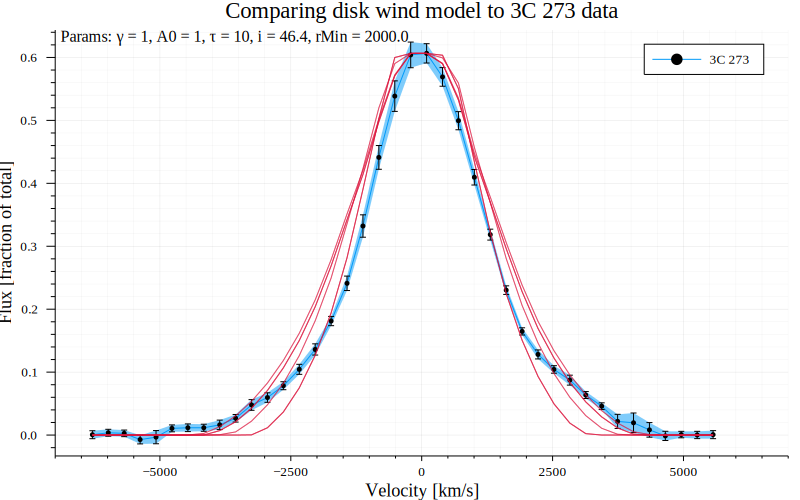

In [112]:
p = plot(vel,data[4],ribbon=data[7],yerr=data[7],marker=:circle,markercolor=:black,markersize=3,label="3C 273")
p = plot!(widen=true,minorgrid=true,xlabel="Velocity [km/s]",ylabel="Flux [fraction of total]",title="Comparing disk wind model to 3C 273 data",size=(800,500),xlims=(-7e3,7e3))
for soln in solutions
    p = plot!(vel,lineProfile(vel,soln),markerstrokewidth=0,label="",lw=1,linealpha=0.5,c=:crimson)
end
p = annotate!((-6900,ylims(p)[2]-0.01,Plots.text("Params: γ = $γ, A0 = $A0, τ = $τ, i = $(round(fit.param[1],sigdigits=3)), rMin = $(round(fit.param[2],sigdigits=3))","times",10,"black",:left)))

# Centroid and phase calculations

In [49]:
function centroid(ν,I,α,β,bins=100)
    xcen,edges,n = binnedStat(vec(ν),vec(I.*α),statistic="sum",bins=bins) #element-wise multiplication to get x/α
    ycen,edges,n = binnedStat(vec(ν),vec(I.*β),statistic="sum",bins=bins) #same but for y/β
    iSum,edges,n = binnedStat(vec(ν),vec(I),statistic="sum",bins=bins) #just total intensty binning
    iSum[iSum.==0.].=1. #it's zero less than rMin, but set to 1 because going to divide
    return xcen./iSum, ycen./iSum #centroids in x/α, y/β, binned along 100 (by default) bins in ν
end

function phase(ν,I,x,y,U,V,bins=100)
    #shape of I is the problem here
    dφMap = @. -2*π*(x*U+y*V)*I*180/π*1e6 #1e6 is units of u,v 180/π to convert rad to deg, gives us corresponding dφ at every ν bin
    dφ,edges,n = binnedStat(vec(ν),vec(dφMap),statistic="sum",bins=bins) #phase binned along ν
    iSum,edges,n = binnedStat(vec(ν),vec(I),statistic="sum",bins=bins) #binned total I
    iSum[iSum.==0.].=1. #set to 1 in places beneath rMin so that we don't divide by 0
    return dφ./iSum
end

phase (generic function with 2 methods)

In [16]:
#check phases
U = [60.,45.,0.]; V = [0.,45.,60.]; blRange=3e8*2e33*6.67e-8/9e20/548/3.09e24 #c*msun*G/some other stuff, u,v (NOT nu) telescope baselines in units of λ
x=reshape(α.*blRange,(nx,ny)); y=reshape(β.*blRange,(nx,ny)); dφList = [] #each index will have maximal wind case + rotation only case
IWind,γ,A0,τ = getIntensity(r,φ,1,sini,rMin); IDisk,γ,A0,τ = getIntensity(r,φ,0,sini,rMin)
for i=1:length(U)
    push!(dφList,(phase(ν,IWind,x,y,U[i],V[i]),phase(ν,IDisk,x,y,U[i],V[i])))
end

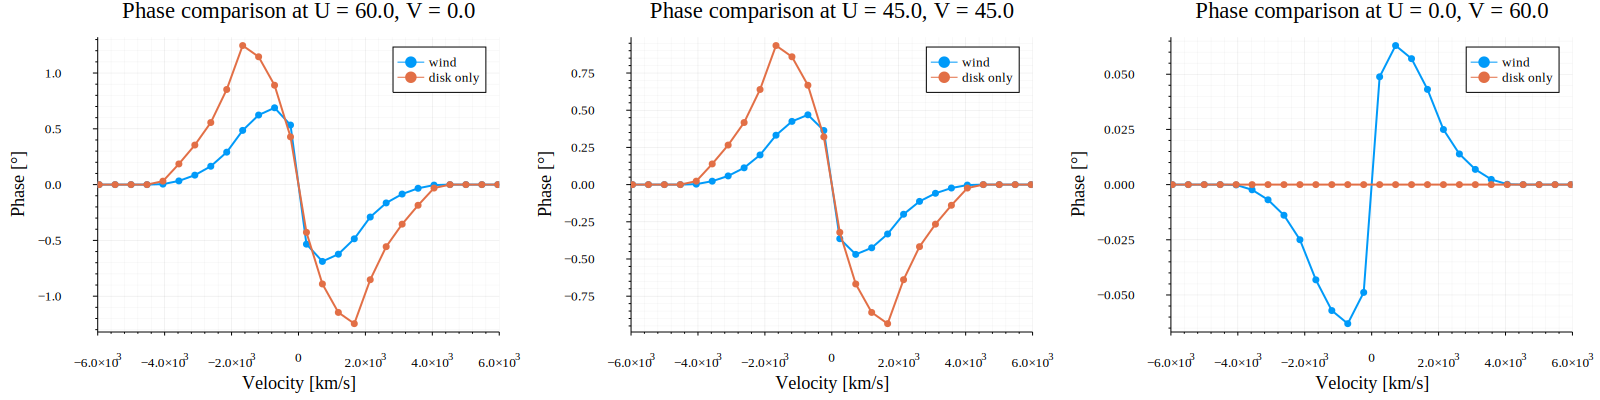

In [68]:
#fline=spec/np.max(spec)*0.6/(1.+spec/np.max(spec)*0.6)
bins = 100
fluxW,νEdges,n=binnedStat(vec(ν),vec(IWind),statistic="sum",bins=bins)
fluxD,νEdges,n=binnedStat(vec(ν),vec(IDisk),statistic="sum",bins=bins)
νBin = 0.5*(νEdges[2:end].+νEdges[1:end-1])
flineD = fluxD./maximum(fluxD)*0.6./(1 .+ fluxD./maximum(fluxD).*0.6)
flineW = fluxW./maximum(fluxW)*0.6./(1 .+ fluxW./maximum(fluxW).*0.6)
function phasePlot(νBin,dφList,U,V,ind,flineW,flineD)
    p=plot((νBin.-1).*3e5,dφList[ind][1].*flineW,label="wind",lw=2,marker=:circle,markerstrokewidth=0)
    p=plot!((νBin.-1).*3e5,dφList[ind][2].*flineD,label="disk only",lw=2,marker=:circle,markerstrokewidth=0)
    p=plot!(title="Phase comparison at U = $(U[ind]), V = $(V[ind])",left_margin=5mm,bottom_margin=5mm,right_margin=5mm,top_margin=5mm)
    p=plot!(xlabel="Velocity [km/s]",ylabel="Phase [°]",minorgrid=true,minorticks=true,xlims=(-6e3,6e3),widen=true)
    return p
end
p1=phasePlot(νBin,dφList,U,V,1,flineW,flineD); p2=phasePlot(νBin,dφList,U,V,2,flineW,flineD); p3=phasePlot(νBin,dφList,U,V,3,flineW,flineD)
plot(p1,p2,p3,size=(1600,400),layout=@layout([a b c]),bottom_margin=10mm,left_margin=10mm)

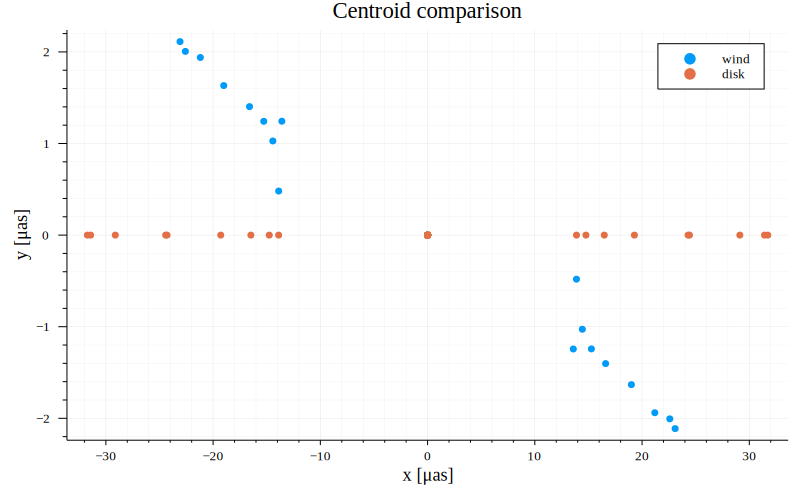

In [56]:
#first show all of them
α = reshape(α,(nx,ny)); β = reshape(β,(nx,ny))
xCWind,yCWind = centroid(ν,IWind,α,β)
xCDisk,yCDisk = centroid(ν,IDisk,α,β)
lim=2e4*blRange/4.85e-12 #weird constant nonsense
scatter(xCWind.*blRange/4.85e-12,yCWind.*blRange/4.85e-12,marker=:circle,markerstrokewidth=0,label="wind")
scatter!(xCDisk.*blRange/4.85e-12,yCDisk.*blRange/4.85e-12,marker=:circle,markerstrokewidth=0,label="disk")
plot!(xlabel="x [μas]",ylabel="y [μas]",minorgrid=true,minorticks=true,title="Centroid comparison",size=(800,500),bottom_margin=5mm,left_margin=5mm,widen=true)

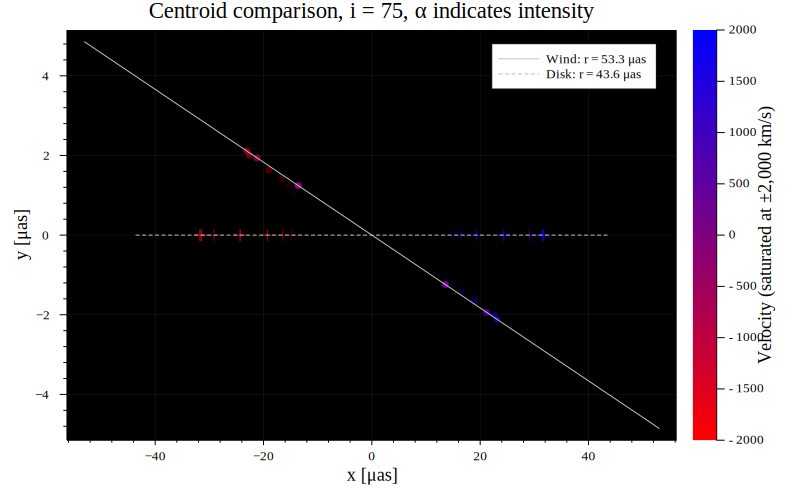

In [113]:
#now let's do a better version with blue/redshifts, the centroid inds should correspond to bins in νBin, should generalize functionally (same with above, maybe display side by side)
meanRW = sum(vec(IWind).*vec(r))/sum(vec(IWind))*blRange/4.85e-12; meanRD = sum(vec(IDisk).*vec(r))/sum(vec(IDisk))*blRange/4.85e-12 #mean weighted radii in μas
plot(xlabel="x [μas]",ylabel="y [μas]",minorgrid=true,minorticks=true,title="Centroid comparison, i = $i, α indicates intensity",size=(800,500),bottom_margin=5mm,left_margin=5mm,widen=true,
    colorbar_title="Velocity (saturated at ±2,000 km/s)",right_margin=5mm,background_color_inside=:black,foreground_color_grid=:white)
scatter!(xCWind.*blRange/4.85e-12,yCWind.*blRange/4.85e-12,marker=:circle,markerstrokewidth=0,zcolor=((νBin.-1).*3e5),m=cgrad([:red,:blue],10),clim=(-2e3,2e3),
    label="",markeralpha=fluxW./maximum(fluxW))
scatter!(xCDisk.*blRange/4.85e-12,yCDisk.*blRange/4.85e-12,marker=:circle,markerstrokewidth=0,zcolor=((νBin.-1).*3e5),m=cgrad([:red,:blue],10),clim=(-2e3,2e3),
    label="",markershape=:cross,markersize=6,markeralpha=fluxD./maximum(fluxD))
tiltW = atan(minimum(xCWind),maximum(yCWind))
plot!([-meanRW*sin(tiltW),meanRW*sin(tiltW)],[-meanRW*cos(tiltW),meanRW*cos(tiltW)],label="Wind: r = $(round(meanRW,sigdigits=3)) μas",c=:silver)
plot!([-meanRD,meanRD],[0.,0.],label="Disk: r = $(round(meanRD,sigdigits=3)) μas",linestyle=:dash,c=:silver)
